# Initialization

## Imports

In [1]:
import numpy as np
import pandas as pd
import ml_tune_helpers.arima.arima_cv_predictor as arima_cvpred
from ml_tune_helpers.arima.stat_tests import StatTestWrapper
from ml_tune_helpers.arima.transformations import TransformHelper
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.api import SimpleExpSmoothing
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Constants

In [2]:
TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

CSV_JOINT_FILE = '../../datasources/ds_joint/ds.csv'

POL_CODES = [7, 6001, 5, 8]
POL_NAMES = {7: "O3", 6001: "PM25", 5: "PM10", 8: "NO2"}

WEATHER_USE_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']
AQI_USE_COLUMNS = ['AQI_O3', 'AQI_PM25', 'AQI_PM10', 'AQI_NO2', 'AQI']
CONC_MEAN_USE_COLUMNS = ['C_mean_O3', 'C_mean_PM25', 'C_mean_PM10', 'C_mean_NO2']

## Data load

In [3]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')
df_weather = df_joint.loc[TRAIN_DATE_FROM:VAL_DATE_TO, WEATHER_USE_COLUMNS]
df_joint = df_joint.loc[TRAIN_DATE_FROM:VAL_DATE_TO, AQI_USE_COLUMNS]

In [4]:
df = df_joint['AQI_PM25'].to_frame()
column_name = 'AQI_PM25'

In [5]:
df_weather.describe()

,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,pres
count,2945.000000,2945.000000,2945.000000,709.000000,2675.000000,2706.000000,1652.000000,2935.000000
mean,11.329304,7.749236,14.766553,2.477856,194.585794,16.086511,40.756416,1015.895060
std,5.930431,5.606548,6.788618,4.908983,90.802512,8.029113,19.179388,10.027877
min,-5.700000,-10.200000,-4.400000,0.000000,0.000000,2.100000,11.100000,976.000000
25%,6.800000,3.500000,9.500000,0.000000,133.000000,10.500000,29.000000,1010.000000
50%,11.100000,7.700000,14.500000,0.000000,212.000000,14.600000,36.000000,1016.700000
75%,16.200000,12.200000,20.000000,2.600000,255.000000,20.300000,50.000000,1022.400000
max,28.600000,21.700000,37.200000,35.700000,359.000000,155.400000,356.000000,1046.900000


In [6]:
df_weather.isna().sum()

tavg      13
tmin      13
tmax      13
prcp    2249
wdir     283
wspd     252
wpgt    1306
pres      23
dtype: int64

In [7]:
df_weather['prcp'].fillna(0, inplace=True)
df_weather['wpgt'].fillna(0, inplace=True)
df_weather['tavg'].fillna(df_weather['tavg'].interpolate(option='time'), inplace=True)
df_weather['tmin'].fillna(df_weather['tmin'].interpolate(option='time'), inplace=True)
df_weather['tmax'].fillna(df_weather['tmax'].interpolate(option='time'), inplace=True)
df_weather['wdir'].fillna(df_weather['wdir'].interpolate(option='time'), inplace=True)
df_weather['wspd'].fillna(df_weather['wspd'].interpolate(option='time'), inplace=True)
df_weather['pres'].fillna(df_weather['pres'].interpolate(option='time'), inplace=True)
df_weather.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
wpgt    0
pres    0
dtype: int64

# Statistical analysis

## Stationary

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - без дифференцирования
The ADF test statistic -6.811083    pvalue: 0.00   maximal Lag: 21   critical values: {'1%': -3.4325792324650255, '5%': -2.8625249273648, '10%': -2.567294304068075}
ADF: stationary
The KPSS test statistic 0.091535    pvalue: 0.10   maximal Lag: 25   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


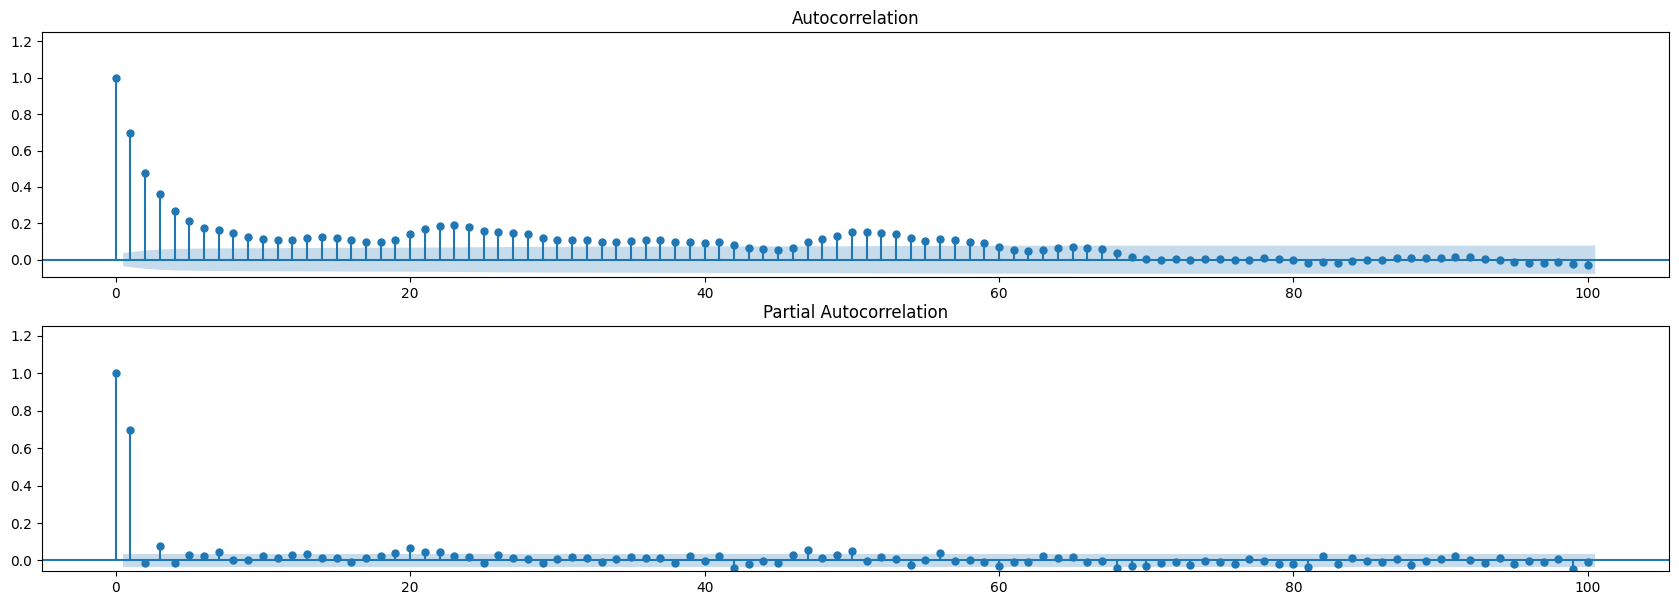

In [10]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - без дифференцирования')
df_diff = StatTestWrapper.pre_analise(df, column_name=column_name, lags=100)

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году
The ADF test statistic -14.652337    pvalue: 0.00   maximal Lag: 6   critical values: {'1%': -3.4328812463201746, '5%': -2.8626583075270813, '10%': -2.5673653156355627}
ADF: stationary
The KPSS test statistic 0.138026    pvalue: 0.10   maximal Lag: 21   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


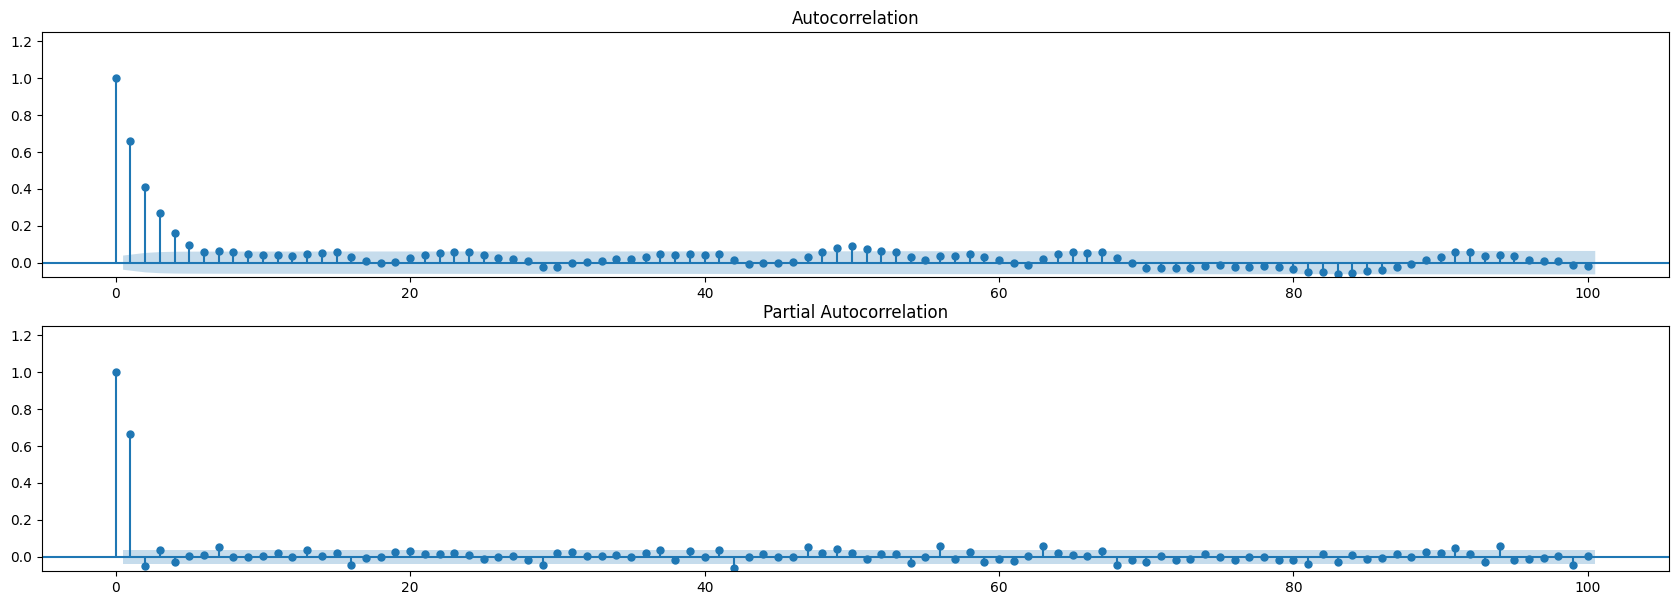

In [11]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году')
df_diff = StatTestWrapper.pre_analise(df, column_name=column_name, diffs_needed=[('Y', 1)], lags=100)

## Trend/seasonality decomposition

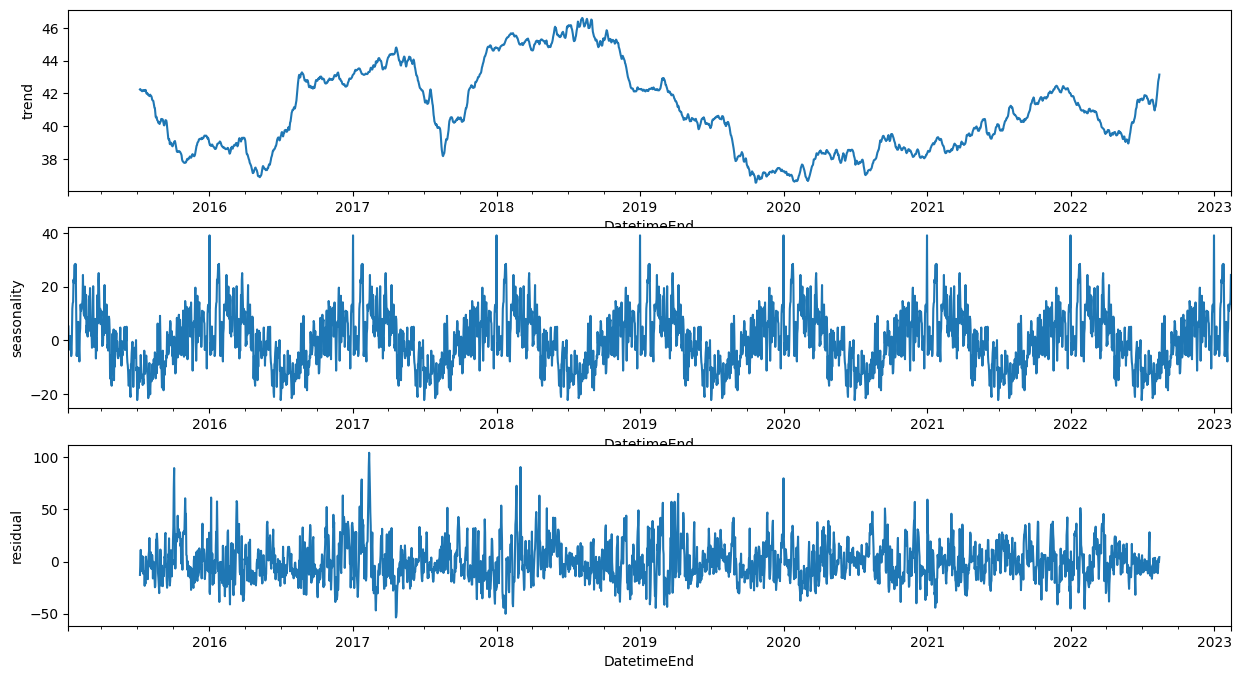

In [13]:
res = seasonal_decompose(df, model = "additive",period = 365)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.seasonal.plot(ax=ax2,ylabel = "seasonality")
res.resid.plot(ax=ax3,ylabel = "residual")
plt.show()

# SARIMAX

## Auto arima - D and d

In [14]:
print('Подбор дифференцирования по тренду с помощью модуля pmdarima:')
print(f'Adf test, d: {ndiffs(df, test="adf")}')
print(f'KPSS test, d: {ndiffs(df, test="kpss")}')

Подбор дифференцирования по тренду с помощью модуля pmdarima:
Adf test, d: 0
KPSS test, d: 0


In [15]:
print('Подбор дифференцирования по сезону с помощью модуля pmdarima:')
print(f'Canova-Hansen test, m=365, D: {nsdiffs(df, m=365, max_D=1, test="ch")}')
print(f'OCSB test, m=365, D: {nsdiffs(df, m=365, max_D=7, test="ocsb")}')
print(f'Canova-Hansen test, m=30, D: {nsdiffs(df, m=30, max_D=6, test="ch")}')
print(f'OCSB test, m=30, D: {nsdiffs(df, m=30, max_D=6, test="ocsb")}')
print(f'Canova-Hansen test, m=7, D: {nsdiffs(df, m=7, max_D=5, test="ch")}')
print(f'OCSB test, m=7, D: {nsdiffs(df, m=7, max_D=5, test="ocsb")}')

Подбор дифференцирования по сезону с помощью модуля pmdarima:
Canova-Hansen test, m=365, D: 1
OCSB test, m=365, D: 0
Canova-Hansen test, m=30, D: 0
OCSB test, m=30, D: 0
Canova-Hansen test, m=7, D: 0
OCSB test, m=7, D: 0


## Auto arima - (pdq)(PDQ)[m]

In [17]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     max_p=7, max_q=7,
                     seasonal=False,
                     d=1,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(4,1,1)(0,0,0)[0]  AIC=24898.680

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25407.085, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25351.547, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25310.001, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25405.093, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24910.849, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24905.828, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25229.659, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24901.747, Time=0.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25204.933, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24898.680, Time=0.75 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=25160.441, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24900.675, Time=0.91 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24900.717, Time=1.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24899.537, Time=0.81 sec
 ARIMA(5,1,0)(0,0,0

In [ ]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     start_P=0, start_Q=0,
                     max_p=7, max_q=2,
                     seasonal=True,
                     d=1, D=1, m=12, trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
#ARIMA(6,1,0)(2,1,0)[12]             : AIC=25776.020
# out of memory

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=27368.157, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=26389.961, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=27314.136, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=26047.284, Time=0.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=26109.921, Time=0.77 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=25926.142, Time=1.66 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=26253.059, Time=0.52 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=14.30 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=25896.852, Time=1.72 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=26219.281, Time=0.56 sec
 ARIMA(3,1,0)(2,1,1)[12]          

In [ ]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     start_P=0, start_Q=0,
                     max_p=7, max_q=7,
                     seasonal=True,
                     #stationary=True,
                     D=1, m=12,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
#ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=25554.076
# out of memory

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=28440.614, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=25880.684, Time=1.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=28438.828, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=26824.790, Time=0.27 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=25562.453, Time=4.89 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.84 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=27163.902, Time=3.39 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=25561.169, Time=6.36 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=25875.802, Time=1.44 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.58 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=25554.800, Time=8.24 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept 

In [15]:
model = pm.auto_arima(df,
                     test='adf',
                     start_p=0, start_q=0,
                     max_p=7, max_q=7,
                     seasonal=False,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
# ARIMA(5,0,1)(0,0,0)[0] AIC=24917.289

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31206.933, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25314.405, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=28529.330, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=25281.897, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=25186.428, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=25170.635, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=25136.212, Time=0.15 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=25110.722, Time=0.18 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=25079.697, Time=0.26 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=24913.136, Time=0.91 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=24911.226, Time=0.71 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=24909.225, Time=0.61 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=24912.314, Time=0.50 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=24916.205, Time=0.75 sec
 ARIMA(4,0,2)(0,0,0

## SARIMAX different model tests

In [9]:
df_train = df.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
df_val = df.loc[VAL_DATE_FROM:VAL_DATE_TO,]

### SARIMAX trend_no_season (4,1,1)(0,0,0,0), exog = None, AUC = 24811

In [10]:
model_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(4,1,1)).fit(disp=0)
model_trend_no_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AQI_PM25   No. Observations:                 2951
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -12399.626
Date:                Thu, 02 Mar 2023   AIC                          24811.252
Time:                        20:36:50   BIC                          24847.190
Sample:                    01-08-2015   HQIC                         24824.190
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6690      0.015     43.975      0.000       0.639       0.699
ar.L2         -0.0833      0.020     -4.262      0.000      -0.122      -0.045
ar.L3          0.0723      0.020      3.599      0.000       0.033       0.112
ar.L4         -0.0460      0.017     -2.659      0.008      -0.080      -0.012
ma.L1         -0.9696      0.006   -176.140      0.000      -0.980      -0.959
sigma2       261.9420      5.253     49.865      0.000     251.646     272.238
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               277.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX no_trend_no_season (5,0,1)(0,0,0,0), exog = None, AUC = 24823

In [12]:
model_no_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(5,0,1)).fit(disp=0)
model_no_trend_no_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AQI_PM25   No. Observations:                 2951
Model:               SARIMAX(5, 0, 1)   Log Likelihood              -12404.713
Date:                Thu, 02 Mar 2023   AIC                          24823.427
Time:                        20:39:44   BIC                          24865.356
Sample:                    01-08-2015   HQIC                         24838.521
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6683      0.015    108.130      0.000       1.638       1.699
ar.L2         -0.7519      0.030    -25.025      0.000      -0.811      -0.693
ar.L3          0.1556      0.034      4.519      0.000       0.088       0.223
ar.L4         -0.1184      0.033     -3.575      0.000      -0.183      -0.053
ar.L5          0.0462      0.017      2.664      0.008       0.012       0.080
ma.L1         -0.9690      0.006   -162.055      0.000      -0.981      -0.957
sigma2       261.8958      5.344     49.007      0.000     251.422     272.370
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               279.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fourier transformation for 2 (k=1) and 4 (k=2) series

In [13]:
exog_k1 = TransformHelper.apply_fourier(df)
exog_k2 = TransformHelper.apply_fourier(df, k_sins=2)

In [14]:
exog_k1_train = exog_k1.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
exog_k1_val =exog_k1.loc[VAL_DATE_FROM:VAL_DATE_TO,]
exog_k2_train = exog_k2.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
exog_k2_val =exog_k2.loc[VAL_DATE_FROM:VAL_DATE_TO,]

### SARIMAX exog_k1 (4,1,1)(0,0,0,0), exog = [Fourier (k=1)], AUC=24764

In [24]:
model_exog_k1 = sm.tsa.statespace.SARIMAX(df_train, order=(4,1,1), exog=exog_k1_train).fit(disp=0)
model_exog_k1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AQI_PM25   No. Observations:                 2951
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -12374.242
Date:                Thu, 02 Mar 2023   AIC                          24764.483
Time:                        20:42:49   BIC                          24812.400
Sample:                    01-08-2015   HQIC                         24781.733
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     2.5830      1.185      2.180      0.029       0.261       4.905
FOURIER_C365-0    10.5342      1.201      8.768      0.000       8.179      12.889
ar.L1              0.6802      0.014     47.904      0.000       0.652       0.708
ar.L2             -0.0798      0.020     -4.077      0.000      -0.118      -0.041
ar.L3              0.0760      0.020      3.789      0.000       0.037       0.115
ar.L4             -0.0375      0.017     -2.196      0.028      -0.071      -0.004
ma.L1             -0.9998      0.004   -272.084      0.000      -1.007      -0.993
sigma2           257.0953      5.244     49.027      0.000     246.817     267.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               305.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX exog_k2 (4,1,1)(0,0,0,0), exog = [Fourier (k=2)], AUC=24765

In [26]:
model_exog_k2 = sm.tsa.statespace.SARIMAX(df_train, order=(4,1,1), exog=exog_k2_train).fit(disp=0)
model_exog_k2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AQI_PM25   No. Observations:                 2951
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -12372.780
Date:                Thu, 02 Mar 2023   AIC                          24765.559
Time:                        20:43:24   BIC                          24825.455
Sample:                    01-08-2015   HQIC                         24787.122
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     2.6331      1.198      2.199      0.028       0.286       4.981
FOURIER_C365-0    10.5458      1.273      8.284      0.000       8.051      13.041
FOURIER_S365-1     0.5697      1.209      0.471      0.638      -1.801       2.940
FOURIER_C365-1    -1.8025      1.188     -1.517      0.129      -4.132       0.527
ar.L1              0.6792      0.014     47.701      0.000       0.651       0.707
ar.L2             -0.0801      0.020     -4.090      0.000      -0.119      -0.042
ar.L3              0.0756      0.020      3.770      0.000       0.036       0.115
ar.L4             -0.0384      0.017     -2.251      0.024      -0.072      -0.005
ma.L1             -0.9997      0.003   -290.265      0.000      -1.006      -0.993
sigma2           256.8332      5.235     49.061      0.000     246.573     267.094
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               304.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Weather exogenous factors

In [29]:
exog_weather = df_weather[['tavg','tmax','wdir','wspd','pres']]
exog_weather_train = exog_weather.loc[TRAIN_DATE_FROM:TRAIN_DATE_TO,]
exog_weather_val = exog_weather.loc[VAL_DATE_FROM:VAL_DATE_TO,]

### SARIMAX trend_no_season_weather (4,1,1)(0,0,0,0) exog=[weather], AUC=24438

In [30]:
model_trend_no_season_weather = sm.tsa.statespace.SARIMAX(df_train ,order=(4,1,1), exog=exog_weather_train).fit(disp=0)
model_trend_no_season_weather.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AQI_PM25   No. Observations:                 2951
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -12207.958
Date:                Thu, 02 Mar 2023   AIC                          24437.915
Time:                        20:47:12   BIC                          24503.801
Sample:                    01-08-2015   HQIC                         24461.634
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg          -2.3580      0.244     -9.652      0.000      -2.837      -1.879
tmax           2.1359      0.184     11.599      0.000       1.775       2.497
wdir          -0.0243      0.003     -7.398      0.000      -0.031      -0.018
wspd          -0.4003      0.039    -10.183      0.000      -0.477      -0.323
pres           0.2482      0.046      5.429      0.000       0.159       0.338
ar.L1          0.5781      0.015     38.613      0.000       0.549       0.607
ar.L2         -0.0715      0.019     -3.828      0.000      -0.108      -0.035
ar.L3          0.0625      0.019      3.244      0.001       0.025       0.100
ar.L4         -0.0524      0.017     -3.026      0.002      -0.086      -0.018
ma.L1         -0.9547      0.007   -129.103      0.000      -0.969      -0.940
sigma2       228.9564      4.372     52.366      0.000     220.387     237.526
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               503.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX exog_k1_weather (4,1,1)(0,0,0,0) exog=[Fourier(k=1), weather], AUC=24377

In [31]:
exog_k1_weather_train = exog_k1_train.merge(exog_weather_train, left_index=True, right_index=True)
exog_k1_weather_val = exog_k1_val.merge(exog_weather_val, left_index=True, right_index=True)

In [32]:
model_exog_k1_weather = sm.tsa.statespace.SARIMAX(df_train, order=(4,1,1), exog=exog_k1_weather_train).fit(disp=0)
model_exog_k1_weather.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AQI_PM25   No. Observations:                 2951
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -12175.833
Date:                Thu, 02 Mar 2023   AIC                          24377.665
Time:                        20:49:00   BIC                          24455.529
Sample:                    01-08-2015   HQIC                         24405.697
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     2.3718      1.017      2.333      0.020       0.379       4.365
FOURIER_C365-0    14.5630      1.482      9.826      0.000      11.658      17.468
tavg              -1.9114      0.249     -7.692      0.000      -2.398      -1.424
tmax               2.0512      0.183     11.192      0.000       1.692       2.410
wdir              -0.0240      0.003     -7.336      0.000      -0.030      -0.018
wspd              -0.4465      0.036    -12.305      0.000      -0.518      -0.375
pres               0.2557      0.045      5.673      0.000       0.167       0.344
ar.L1              0.5934      0.013     44.511      0.000       0.567       0.620
ar.L2             -0.0584      0.019     -3.133      0.002      -0.095      -0.022
ar.L3              0.0644      0.019      3.335      0.001       0.027       0.102
ar.L4             -0.0321      0.017     -1.907      0.057      -0.065       0.001
ma.L1             -0.9978      0.002   -592.712      0.000      -1.001      -0.995
sigma2           224.4074      4.300     52.192      0.000     215.980     232.834
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               664.49
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#AUC 22636: model_trend_no_season = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1)).fit(disp=0)
#AUC 22540: model_exog_k1 = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_train).fit(disp=0)
#AUC 22502: model_no_trend_season = sm.tsa.statespace.SARIMAX(df_train, order=(2,0,2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False).fit(disp=0)
#AUC 22114: model_trend_no_season_weather = sm.tsa.statespace.SARIMAX(df_train ,order=(6,1,1), exog=exog_weather_train).fit(disp=0)
#AUC 22049: model_exog_k1_weather = sm.tsa.statespace.SARIMAX(df_train, order=(6,1,1), exog=exog_k1_weather_train).fit(disp=0)

# Residuals analysis

## SARIMAX trend_no_season (4,1,1)(0,0,0,0), exog = None, AUC = 24811

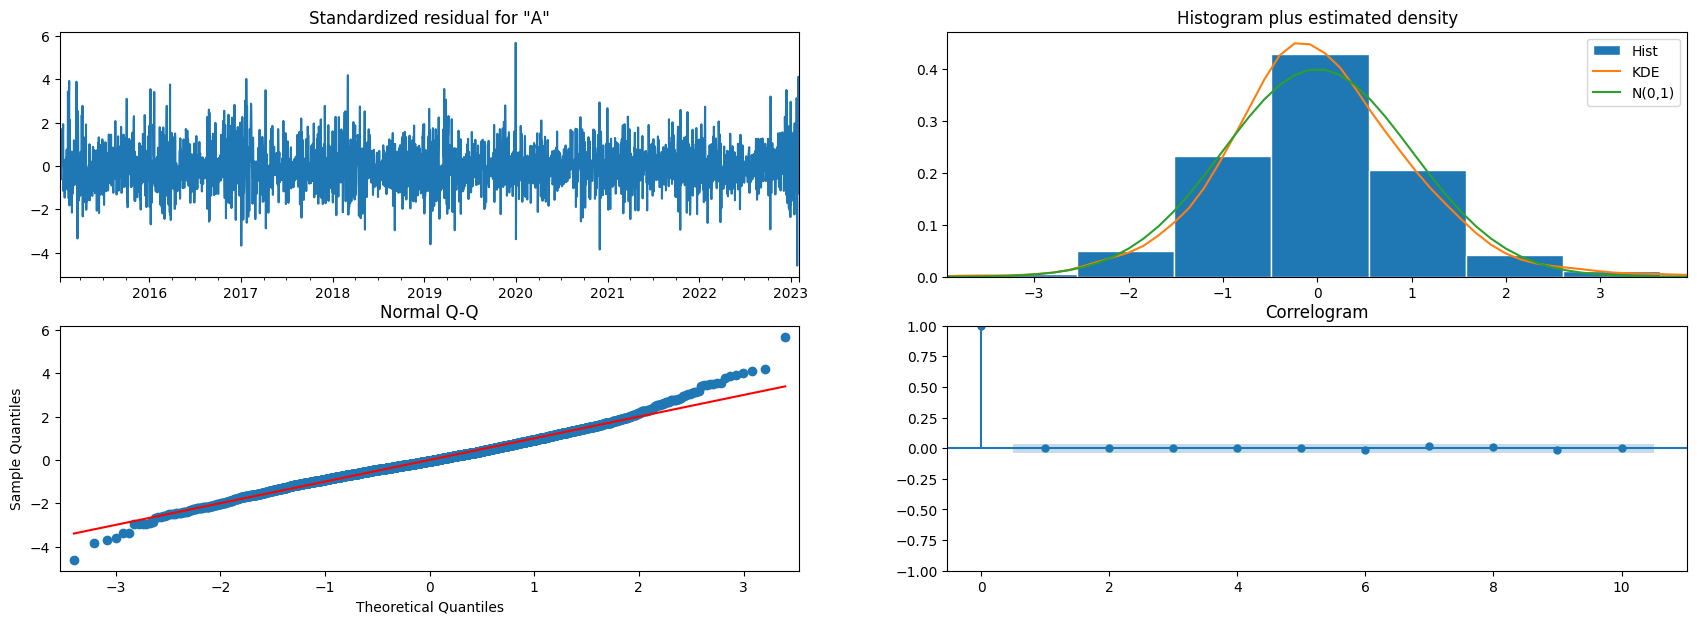

The KPSS test statistic 0.031260    pvalue: 0.10   maximal Lag: 0   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


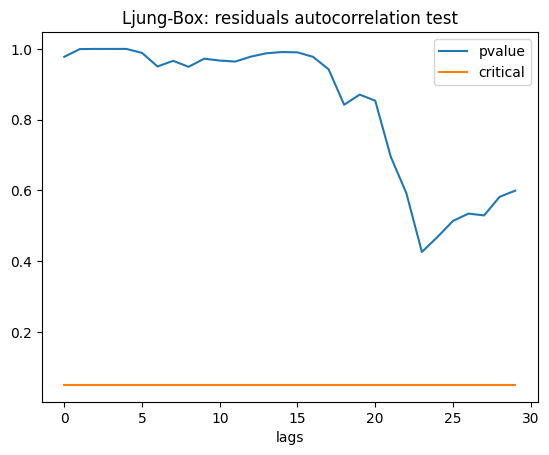

The Durbin-Watson residuals statistics 1.998538
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2132723.000000, pvalue: 0.33
Wilcoxon: residuals are biased


In [11]:
StatTestWrapper.get_residuals_analysis(model_trend_no_season)

## SARIMAX no_trend_no_season (5,0,1)(0,0,0,0), exog = None, AUC = 24823

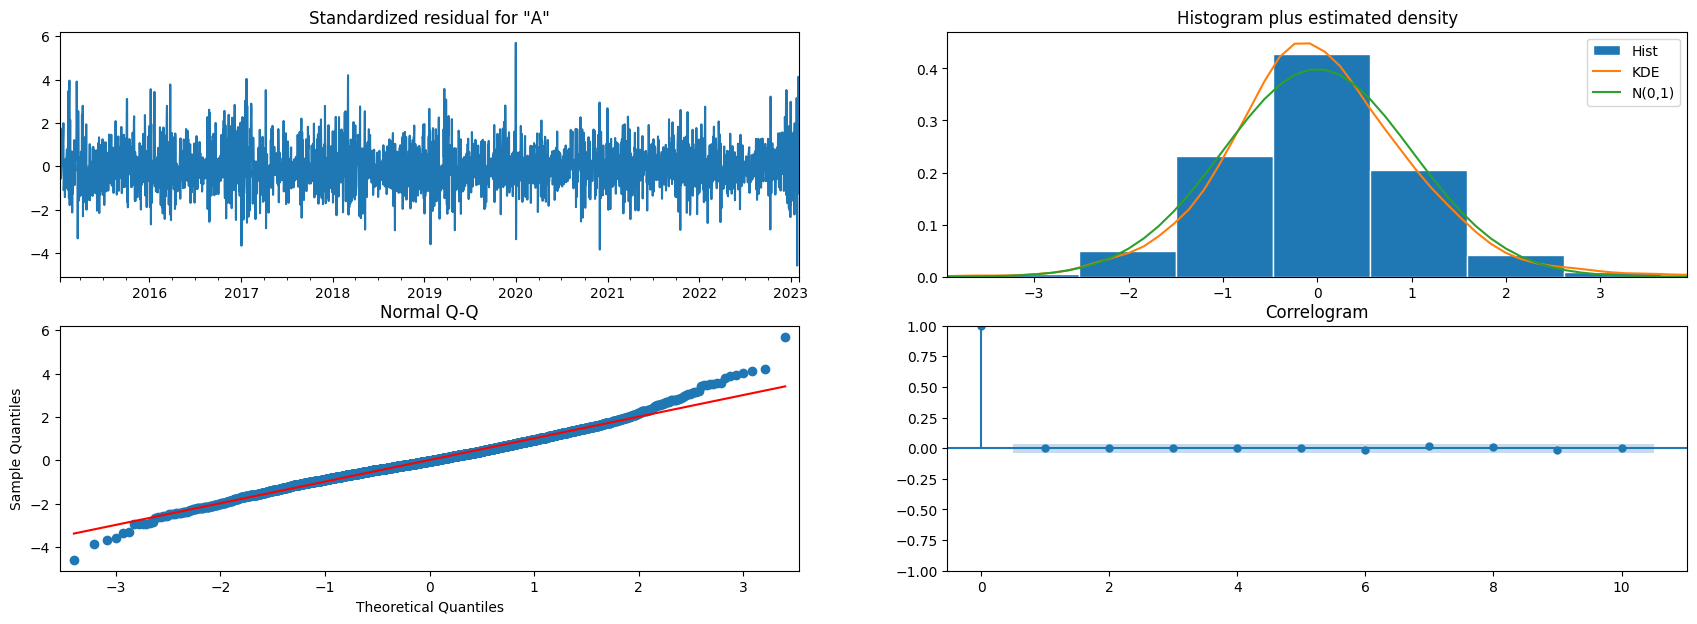

The KPSS test statistic 0.028185    pvalue: 0.10   maximal Lag: 0   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


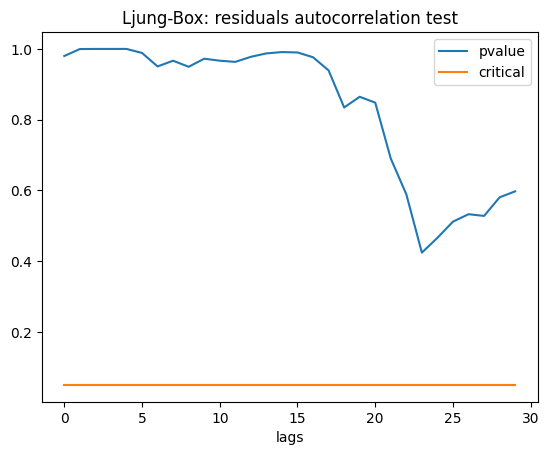

The Durbin-Watson residuals statistics 1.998011
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2164311.000000, pvalue: 0.77
Wilcoxon: residuals are not biased


In [33]:
StatTestWrapper.get_residuals_analysis(model_no_trend_no_season)

## SARIMAX exog_k1 (4,1,1)(0,0,0,0), exog = [Fourier for k=1], AUC = 24764

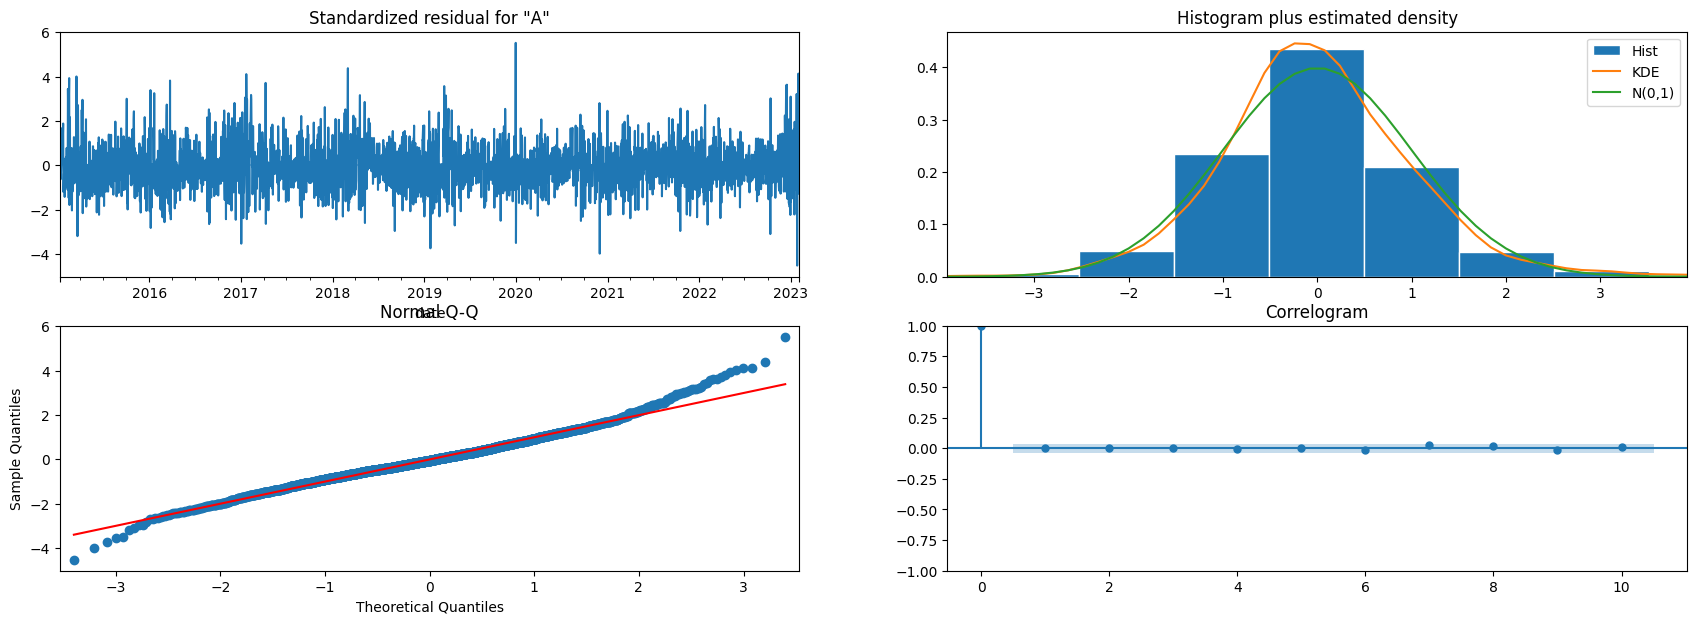

The KPSS test statistic 0.115353    pvalue: 0.10   maximal Lag: 1   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


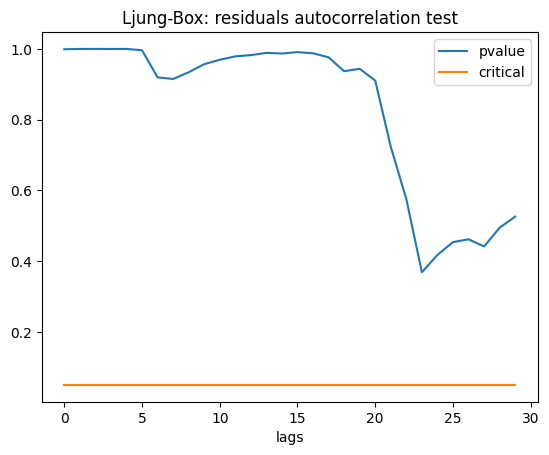

The Durbin-Watson residuals statistics 1.998293
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2095049.000000, pvalue: 0.07
Wilcoxon: residuals are biased


In [34]:
StatTestWrapper.get_residuals_analysis(model_exog_k1)

## SARIMAX trend_no_season_weather (4,1,1)(0,0,0,0), exog = [weather], AUC = 24438

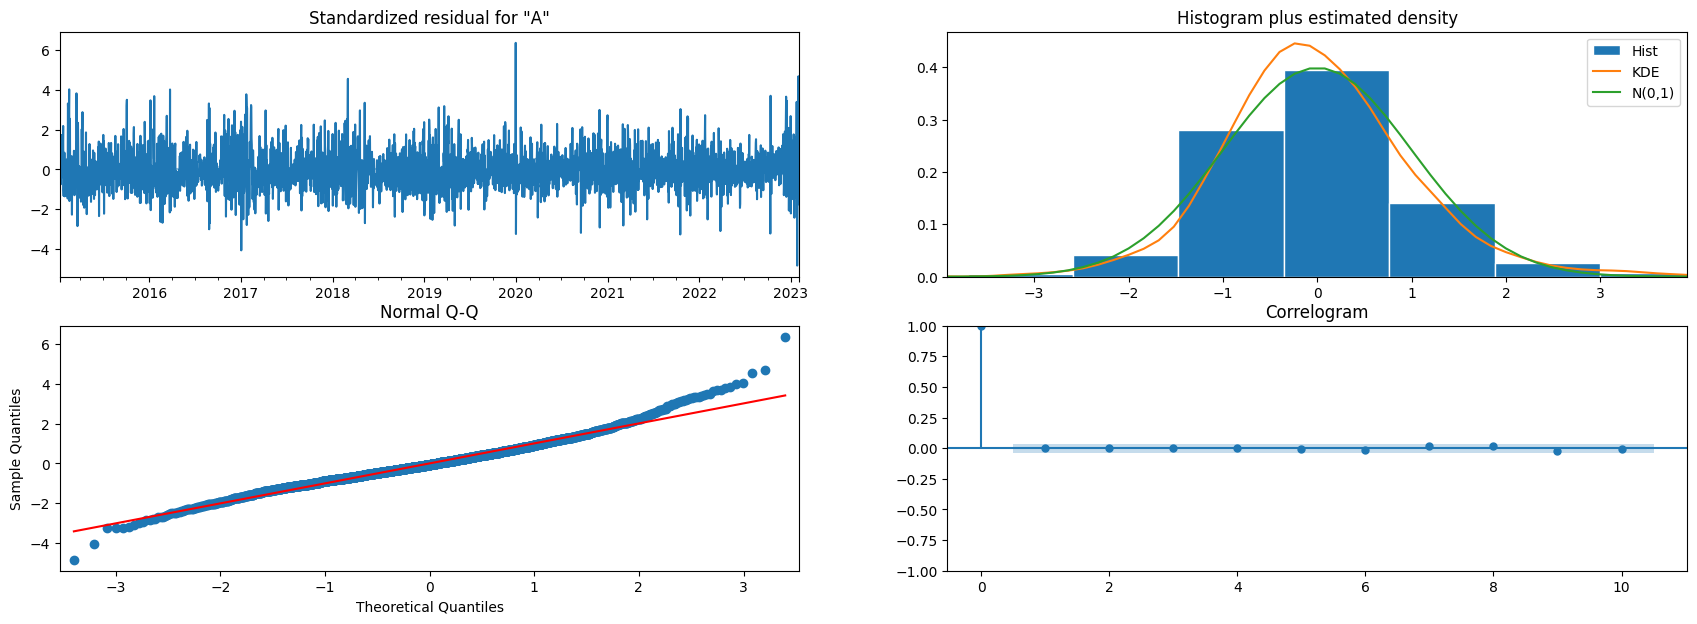

The KPSS test statistic 0.092284    pvalue: 0.10   maximal Lag: 1   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


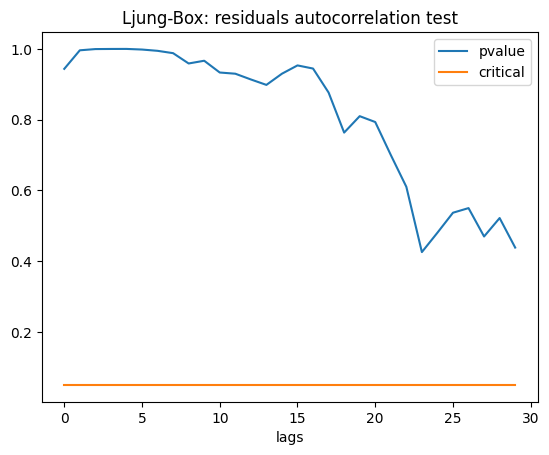

The Durbin-Watson residuals statistics 1.942765
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2095923.000000, pvalue: 0.08
Wilcoxon: residuals are biased


In [35]:
StatTestWrapper.get_residuals_analysis(model_trend_no_season_weather)

## SARIMAX exog_k1_weather (4,1,1)(0,0,0,0), exog = [weather + Fourier k =1], AUC = 24377

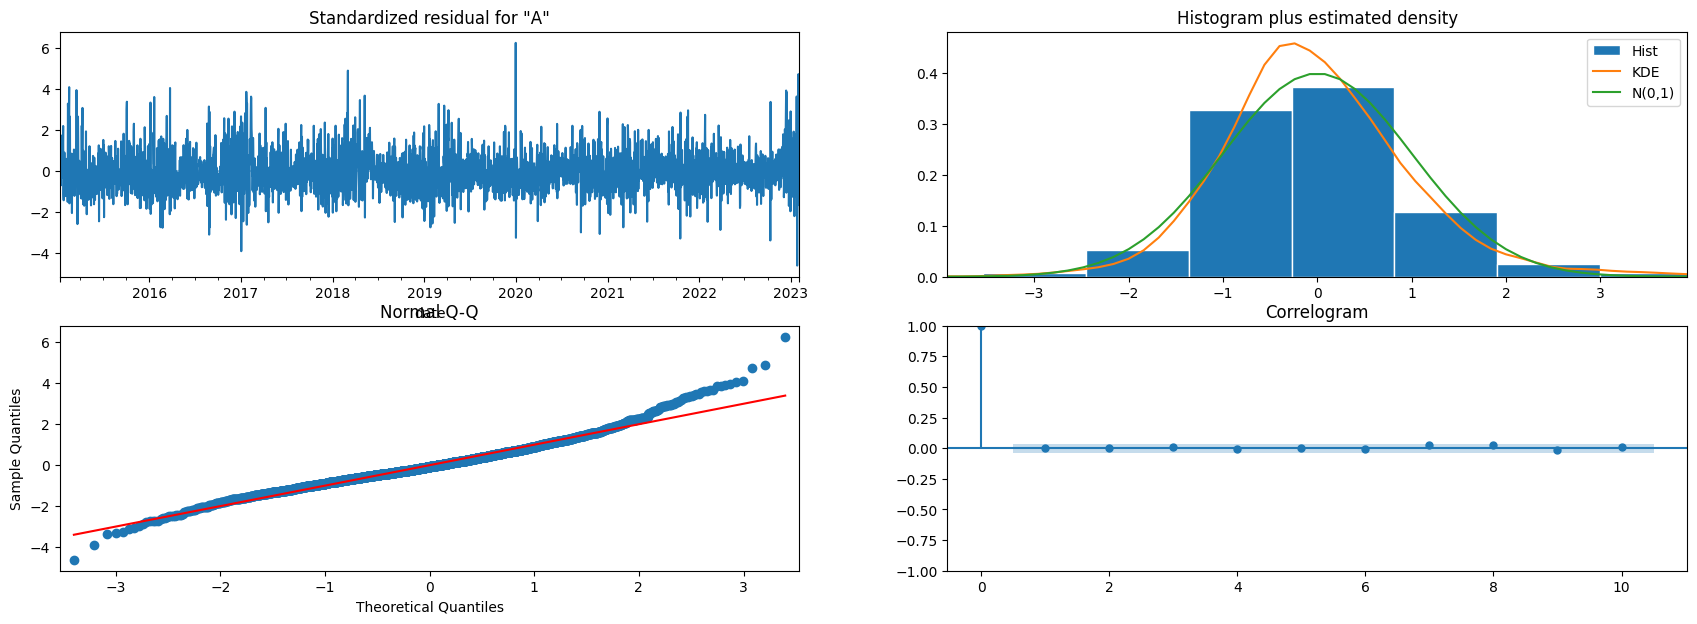

The KPSS test statistic 0.163575    pvalue: 0.10   maximal Lag: 1   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


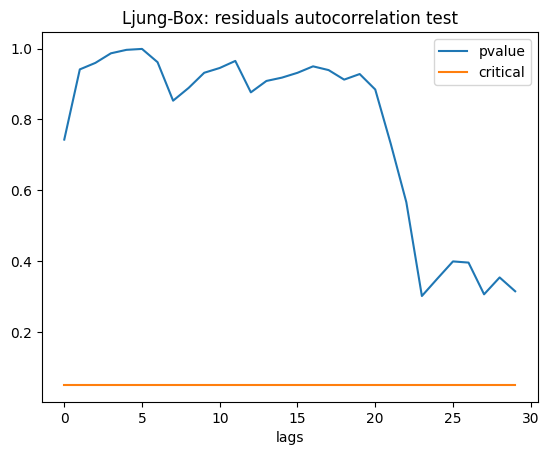

The Durbin-Watson residuals statistics 1.918732
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 2034266.000000, pvalue: 0.00
Wilcoxon: residuals are biased


In [36]:
StatTestWrapper.get_residuals_analysis(model_exog_k1_weather)

# Scores estimation

## SARIMAX trend_no_season (4,1,1)(0,0,0,0), exog = None, AUC = 22811

In [63]:
rmse_train_trend_no_season, train_predictions_trend_no_season = arima_cvpred.cross_val_sarimax_calc_rmse(ts_train=df_train, order=(4,1,1), seasonal_order=None, exog_train=None)
rmse_val_trend_no_season, predictions_trend_no_season = arima_cvpred.predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(4,1,1), seasonal_order=None, exog_train=None, exog_val=None)
rmse_train_trend_no_season, rmse_val_trend_no_season

(23.227805976831473, 62.058428856943834)

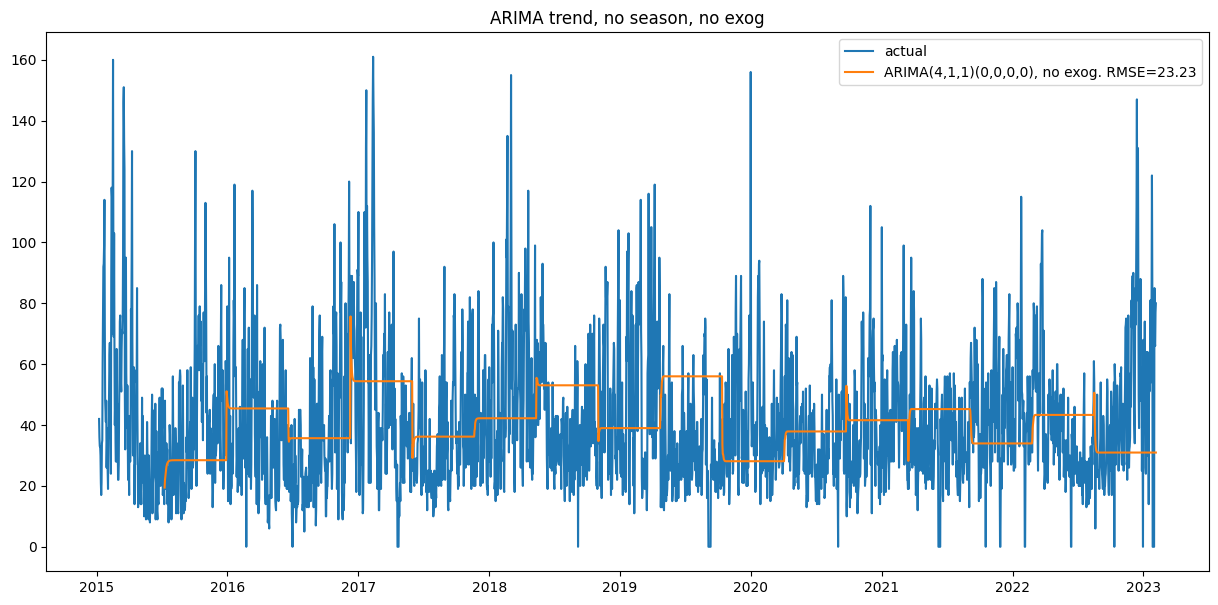

In [64]:
plt.figure(figsize=(15, 7))
plt.title("ARIMA trend, no season, no exog")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_trend_no_season, label="ARIMA(4,1,1)(0,0,0,0), no exog. RMSE=%.2f" % rmse_train_trend_no_season)
plt.legend()
plt.show()

## SARIMAX no_trend_no_season (5,0,1)(0,0,0,0), exog = None, AUC = 22823

In [65]:
rmse_train_no_trend_no_season, train_predictions_no_trend_no_season = arima_cvpred.cross_val_sarimax_calc_rmse(ts_train=df_train, order=(5,0,1), seasonal_order=None, exog_train=None)
rmse_val_no_trend_no_season, predictions_no_trend_no_season = arima_cvpred.predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(5,0,1), seasonal_order=None, exog_train=None, exog_val=None)
rmse_train_no_trend_no_season, rmse_val_no_trend_no_season

(28.83508558445053, 62.55935824246494)

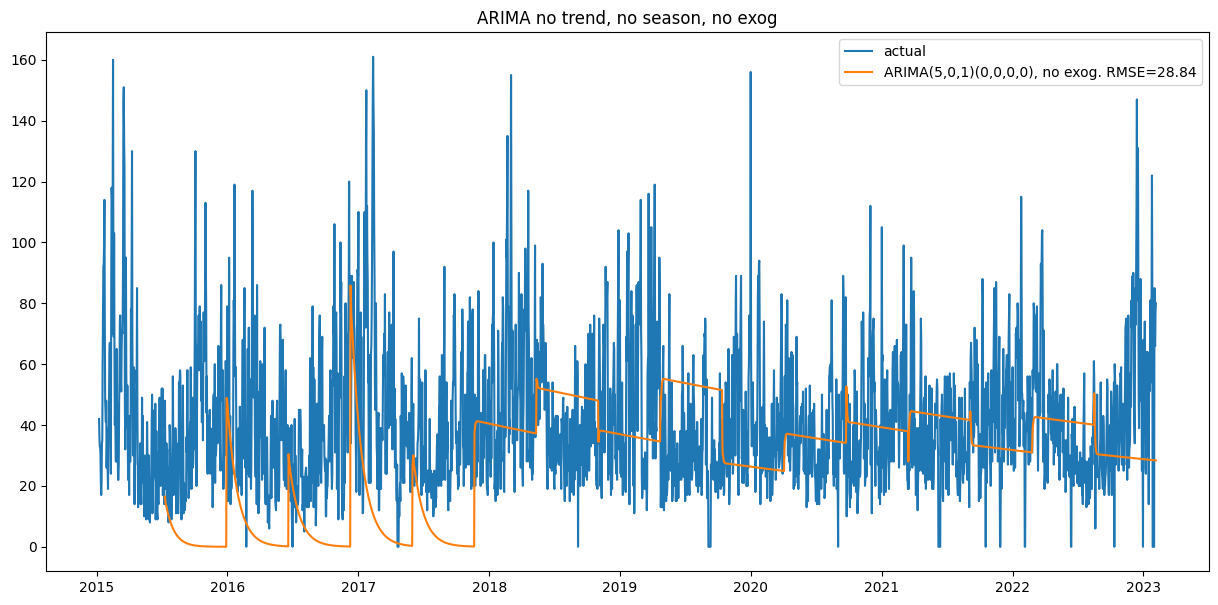

In [69]:
plt.figure(figsize=(15, 7))
plt.title("ARIMA no trend, no season, no exog")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_no_trend_no_season, label="ARIMA(5,0,1)(0,0,0,0), no exog. RMSE=%.2f" % rmse_train_no_trend_no_season)
plt.legend()
plt.show()

## SARIMAX exog_k1 (4,1,1)(0,0,0,0), exog = [Fourier for k=1], AUC = 24764

In [66]:
rmse_train_exog_k1, train_predictions_exog_k1 = arima_cvpred.cross_val_sarimax_calc_rmse(ts_train=df_train, order=(4,1,1), seasonal_order=None, exog_train=exog_k1_train)
rmse_val_exog_k1, predictions_exog_k1 = arima_cvpred.predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(4,1,1), seasonal_order=None, exog_train=exog_k1_train, exog_val=exog_k1_val)
rmse_train_exog_k1, rmse_val_exog_k1

(20.951591276433685, 63.369769402256544)

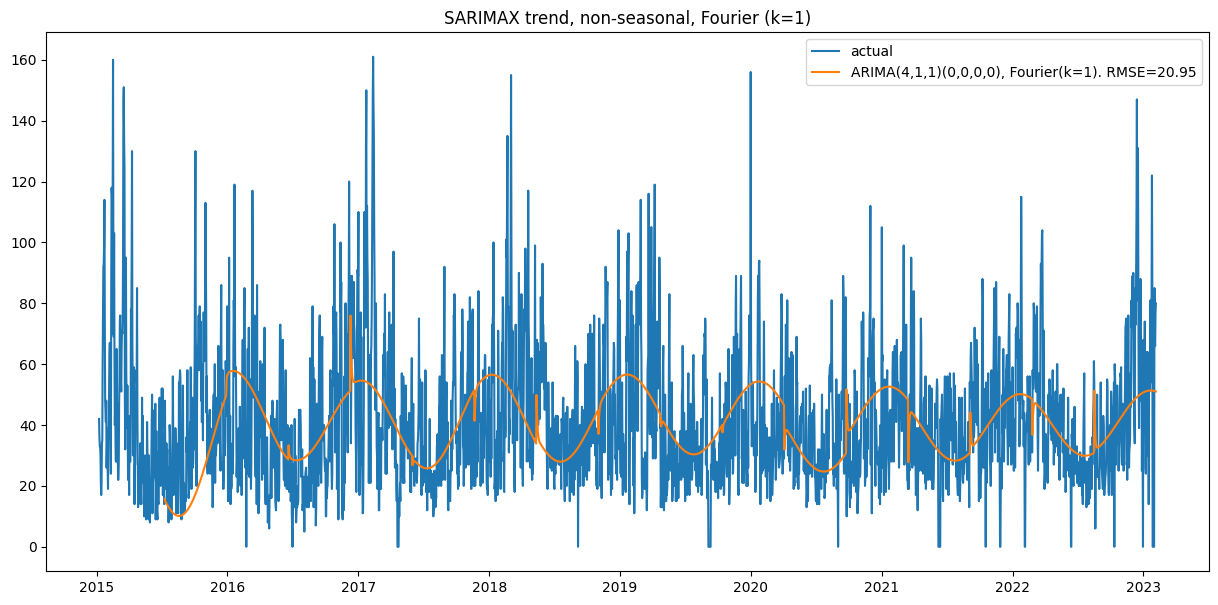

In [46]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX trend, non-seasonal, Fourier (k=1)")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_exog_k1, label="ARIMA(4,1,1)(0,0,0,0), Fourier(k=1). RMSE=%.2f" % rmse_train_exog_k1)
plt.legend()
plt.show()

## SARIMAX trend_no_season_weather (4,1,1)(0,0,0,0) exog = [weather], AUC = 22438

In [70]:
rmse_train_trend_no_season_weather, train_predictions_trend_no_season_weather = arima_cvpred.cross_val_sarimax_calc_rmse(ts_train=df_train, order=(4,1,1), seasonal_order=None, exog_train=exog_weather_train)
rmse_val_trend_no_season_weather, predictions_trend_no_season_weather = arima_cvpred.predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(4,1,1), seasonal_order=None, exog_train=exog_weather_train, exog_val=exog_weather_val)
rmse_train_trend_no_season_weather, rmse_val_trend_no_season_weather

NameError: name 'arima_cvpred' is not defined

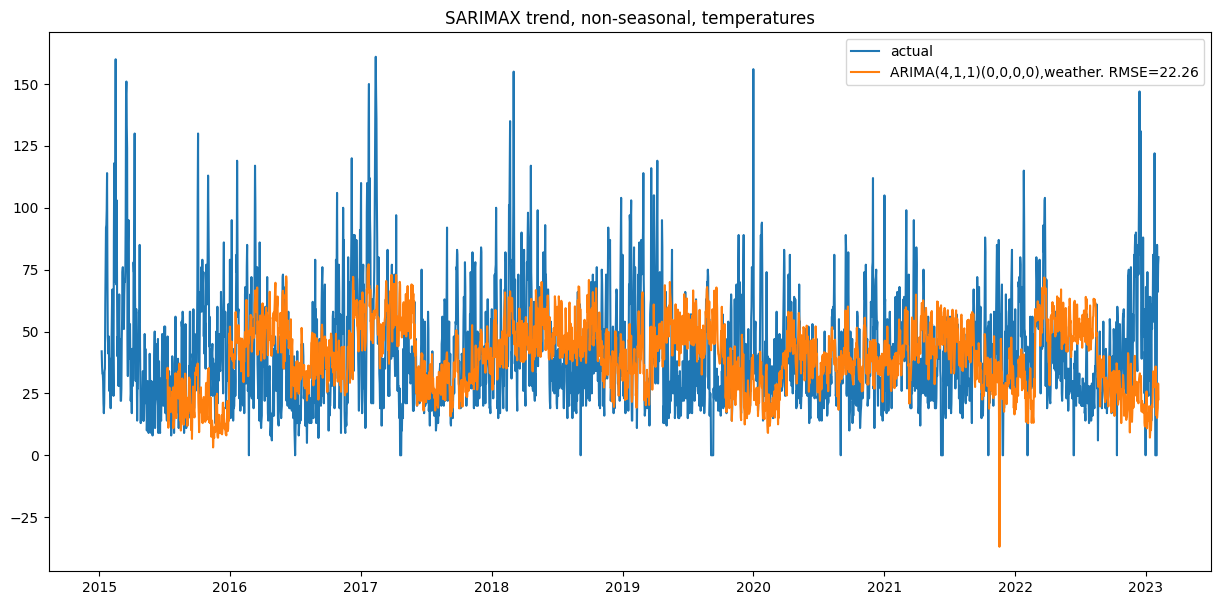

In [71]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX trend, non-seasonal, temperatures")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_trend_no_season_weather, label="ARIMA(4,1,1)(0,0,0,0),weather. RMSE=%.2f" % rmse_train_trend_no_season_weather)
plt.legend()
plt.show()

## SARIMAX exog_k1_weather (4,1,1)(0,0,0,0), exog = [weather + Fourier k =1], AUC = 24377

In [49]:
rmse_train_exog_k1_weather, train_predictions_exog_k1_weather = arima_cvpred.cross_val_sarimax_calc_rmse(ts_train=df_train, order=(4,1,1), seasonal_order=None, exog_train=exog_k1_weather_train)
rmse_val_exog_k1_weather, predictions_exog_k1_weather = arima_cvpred.predict_sarimax_calc_rmse(ts_train=df_train, ts_val=df_val, order=(4,1,1), seasonal_order=None, exog_train=exog_k1_weather_train, exog_val=exog_k1_weather_val)
rmse_train_exog_k1_weather, rmse_val_exog_k1_weather

(18.102478180407605, 53.2812042263063)

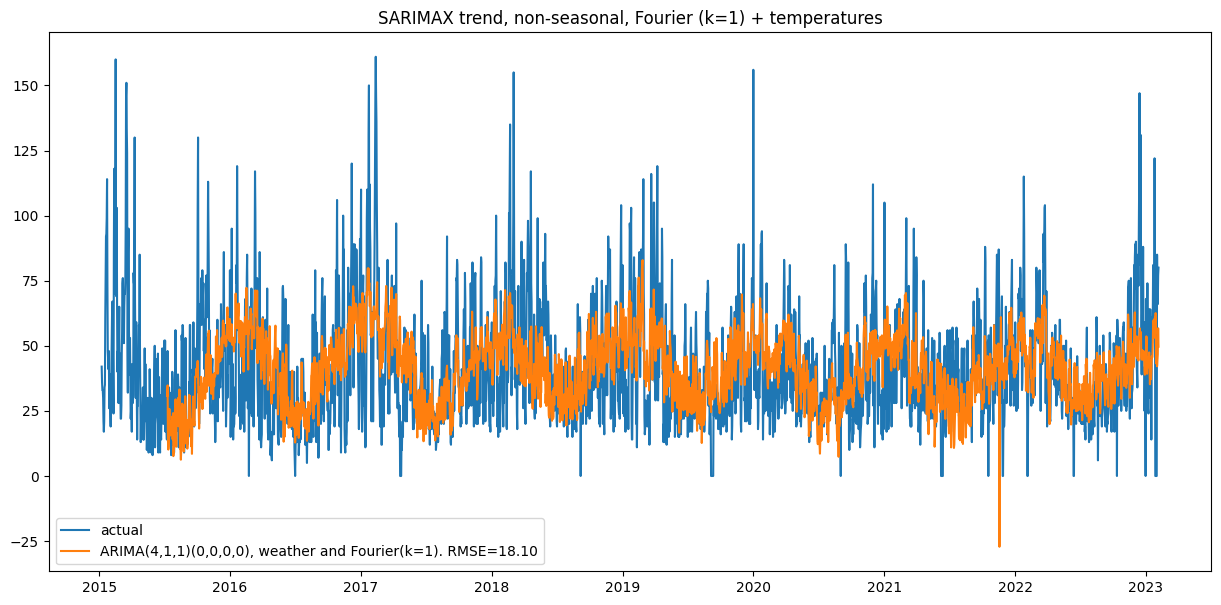

In [72]:
plt.figure(figsize=(15, 7))
plt.title("SARIMAX trend, non-seasonal, Fourier (k=1) + temperatures")
plt.plot(df_train, label="actual")
plt.plot(train_predictions_exog_k1_weather, label="ARIMA(4,1,1)(0,0,0,0), weather and Fourier(k=1). RMSE=%.2f" % rmse_train_exog_k1_weather)
plt.legend()
plt.show()

# Baseline - Simple exponential smoothing

In [51]:
def ses_by_pols(alpha, y_train, y_val):
    ses = SimpleExpSmoothing(y_train)
    model_ses = ses.fit(smoothing_level = alpha, optimized = False)
    y_pred = model_ses.forecast(7)
    y_pred = [int(round(x)) for x in y_pred]
    score = np.sqrt(mean_squared_error(y_val.values, y_pred))
    return score, y_pred

In [52]:
alpha001 = 0.01
rmse_val_ses_a001, predictions_ses_a001_vals = ses_by_pols(alpha001, df_train, df_val)
rmse_val_ses_a001

74.15620578982488

In [53]:
alpha01 = 0.1
rmse_val_ses_a01, predictions_ses_a01_vals= ses_by_pols(alpha01, df_train, df_val)
rmse_val_ses_a01

67.5288298221053

In [54]:
alpha05 = 0.5
rmse_val_ses_a05, predictions_ses_a05_vals= ses_by_pols(alpha05, df_train, df_val)
rmse_val_ses_a05

49.165899913310994

In [55]:
alpha1 = 1
rmse_val_ses_a1, predictions_ses_a1_vals= ses_by_pols(alpha1, df_train, df_val)
rmse_val_ses_a1

43.936642696371

In [56]:
predictions_ses_a1 = pd.DataFrame(index=df_val.index)
predictions_ses_a1[column_name] = rmse_val_ses_a1
predictions_ses_a1

,AQI_PM25
DatetimeEnd,
2023-02-06,43.936643
2023-02-07,43.936643
2023-02-08,43.936643
2023-02-09,43.936643
2023-02-10,43.936643
2023-02-11,43.936643
2023-02-12,43.936643


# Forecast

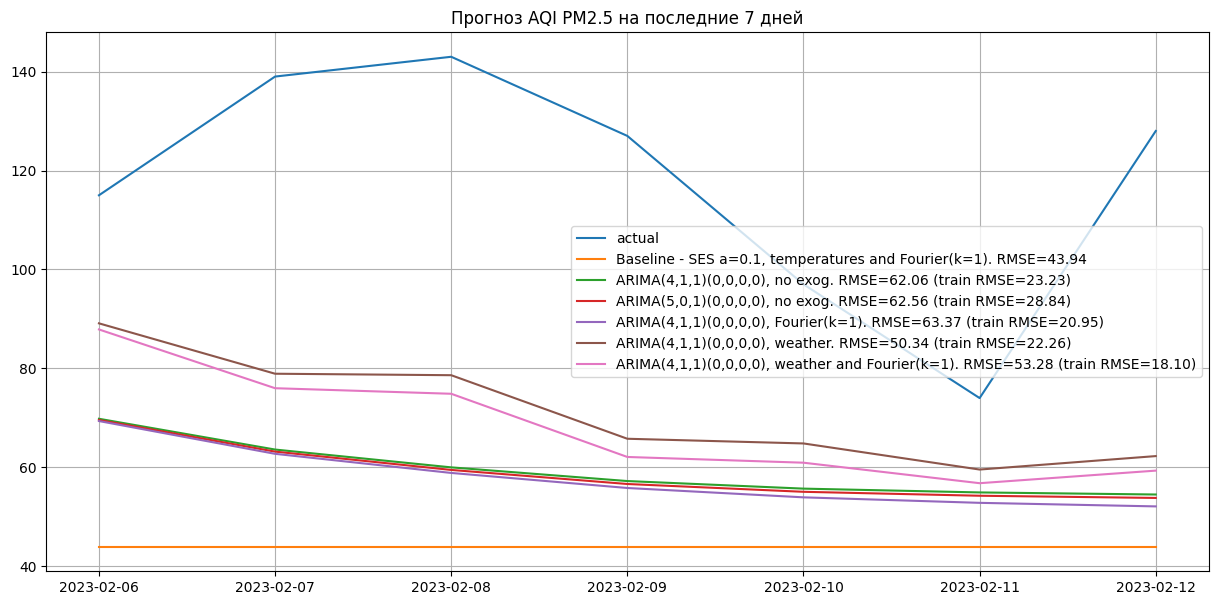

In [59]:
plt.figure(figsize=(15, 7))
plt.title(f"Прогноз AQI PM2.5 на последние 7 дней")
plt.plot(df_val, label="actual")
plt.plot(predictions_ses_a1, label="Baseline - SES a=0.1, temperatures and Fourier(k=1). RMSE=%.2f" % rmse_val_ses_a1)
plt.plot(predictions_trend_no_season, label="ARIMA(4,1,1)(0,0,0,0), no exog. RMSE=%.2f (train RMSE=%.2f)" % (rmse_val_trend_no_season, rmse_train_trend_no_season))
plt.plot(predictions_no_trend_no_season, label="ARIMA(5,0,1)(0,0,0,0), no exog. RMSE=%.2f (train RMSE=%.2f)" % (rmse_val_no_trend_no_season, rmse_train_no_trend_no_season))
plt.plot(predictions_exog_k1, label="ARIMA(4,1,1)(0,0,0,0), Fourier(k=1). RMSE=%.2f (train RMSE=%.2f)" % (rmse_val_exog_k1, rmse_train_exog_k1))
plt.plot(predictions_trend_no_season_weather, label="ARIMA(4,1,1)(0,0,0,0), weather. RMSE=%.2f (train RMSE=%.2f)" % (rmse_val_trend_no_season_weather, rmse_train_trend_no_season_weather))
plt.plot(predictions_exog_k1_weather, label="ARIMA(4,1,1)(0,0,0,0), weather and Fourier(k=1). RMSE=%.2f (train RMSE=%.2f)" % (rmse_val_exog_k1_weather, rmse_train_exog_k1_weather))
plt.plot()
plt.legend()
plt.grid(True)
plt.show()